# **Contents**


1.   Data Importing
2.   Data Preprocessing
  
  a. Normalising the DataFrame

  b. Smoothening the Time-Series Data

  c. Adjusting the RUL after smoothening the dataset


3. Exploratory data analysis for Feature Selection
4.   Models Builiding (trained on GPU)
  
  a. Libraries Importing

  b. Dataset Generating Function for LSTM

  c. Network Architecture

  d. Training of the Model

  e. Testing of the model
  
  f. RUL prediciton




# Dataset

## Mounting GDRive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

!pip install tsmoothie
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

## Data Generating Function

In [3]:
def prepare_data(train_file, num_of_sensors, num_of_operational_setting, test_file,truth_file):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OperationalSetting"+str(i) for i in range(1,num_of_operational_setting+1)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,num_of_sensors+1)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv(train_file,delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(test_file, delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv(truth_file, delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1
    
    return df_train, df_test, y_true

In [4]:
# train_file = '/content/drive/My Drive/Dataset/PdM/train_FD001.txt'
# num_of_sensors =  21
# num_of_operational_setting = 3
# test_file ='/content/drive/My Drive/Dataset/PdM/test_FD001.txt'
# truth_file = '/content/drive/My Drive/Dataset/PdM/RUL_FD001.txt'

In [5]:
train_file = '/content/drive/My Drive/Dataset/PdM/train_FD002.txt'
num_of_sensors =  21
num_of_operational_setting = 3
test_file ='/content/drive/My Drive/Dataset/PdM/test_FD002.txt'
truth_file = '/content/drive/My Drive/Dataset/PdM/RUL_FD002.txt'

In [6]:
# Generating the Dataset
df_train, df_test, y_true = prepare_data(train_file, num_of_sensors, num_of_operational_setting, test_file,truth_file)
df_train.shape, df_test.shape, y_true.shape

((53759, 27), (33991, 26), (259, 2))

In [7]:
df_train.head()

,UnitNumber,Cycle,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


# Data Preprocessing

## Normalising the Data

In [8]:
features_columns = df_train.columns.drop(['RUL','UnitNumber','Cycle'])
features_columns

Index(['OperationalSetting1', 'OperationalSetting2', 'OperationalSetting3',
       'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4',
       'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8',
       'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11',
       'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14',
       'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17',
       'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20',
       'SensorMeasure21'],
      dtype='object')

In [9]:
def normalize(df,features):
  mms = MinMaxScaler(feature_range=(-1,1))
  df[features] = mms.fit_transform(df[features])
  return df


In [10]:
train_data = normalize(df_train, features_columns)
test_data = normalize(df_test, features_columns)

train_data

,UnitNumber,Cycle,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,0.666268,0.995249,1.0,-0.879462,-0.636847,-0.377597,-0.453810,-0.706816,-0.711950,-0.723927,0.300114,-0.420616,-0.513514,-0.057003,-0.726367,0.984788,-0.046984,-0.260105,-1.0,-0.354167,0.302326,1.0,-0.687929,-0.681836,148
1,1,2,0.999533,0.997150,1.0,-1.000000,-0.736306,-0.406799,-0.508930,-1.000000,-1.000000,-0.991838,0.253325,-0.482319,-0.513514,-0.027687,-0.993405,0.984457,0.066026,-0.237185,-1.0,-0.437500,0.255814,1.0,-0.984225,-0.970875,147
2,1,3,0.190192,0.476960,-1.0,-0.523822,-0.967336,-0.929405,-0.886006,-0.413632,-0.583648,-0.814281,-0.998564,-0.974213,-0.945946,-0.925081,-0.821940,-0.997685,-0.921407,0.873462,-1.0,-0.875000,-1.000000,-1.0,-0.732510,-0.697172,146
3,1,4,0.999986,0.999050,1.0,-1.000000,-0.743463,-0.402411,-0.506041,-1.000000,-1.000000,-0.992077,0.253368,-0.482319,-0.513514,-0.066775,-0.991883,0.984182,0.048698,-0.255199,-1.0,-0.458333,0.255814,1.0,-0.971879,-0.947712,145
4,1,5,0.190273,0.473397,-1.0,-0.523822,-0.971741,-0.924258,-0.883695,-0.413632,-0.582390,-0.817431,-0.998606,-0.987529,-0.945946,-0.892508,-0.821484,-0.997850,-0.938735,0.875073,-1.0,-0.875000,-1.000000,-1.0,-0.729081,-0.713520,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,-0.047624,0.662708,1.0,0.253970,0.344344,0.364594,0.182978,0.015873,0.000000,-0.058756,0.731979,0.409170,-0.243243,0.382736,-0.061864,0.991953,0.529395,-0.291301,1.0,0.375000,0.729387,1.0,-0.027435,-0.032014,4
53755,260,313,-0.523795,-0.403800,1.0,0.195873,0.289660,0.466017,0.445867,0.234360,0.231447,0.220276,0.707698,0.512560,0.783784,0.604235,0.228155,0.988646,0.889846,-0.690319,1.0,0.479167,0.708245,1.0,0.229081,0.244044,3
53756,260,314,0.190445,0.472684,-1.0,-0.523822,-0.964217,-0.823866,-0.835604,-0.413632,-0.581132,-0.817145,-0.989021,-0.790635,-0.945946,-0.851792,-0.824375,-0.985008,-0.415005,0.999121,-1.0,-0.854167,-1.000000,-1.0,-0.724966,-0.711051,2
53757,260,315,0.190407,0.477435,-1.0,-0.523822,-0.957611,-0.841690,-0.795263,-0.413632,-0.581132,-0.818577,-0.989063,-0.793399,-0.945946,-0.822476,-0.821179,-0.984898,-0.409197,0.990334,-1.0,-0.833333,-1.000000,-1.0,-0.734568,-0.731234,1


## Smoothening the Data

In [11]:
def smoothening(df,features,window):
  df_smoothed = df.groupby('UnitNumber')[features].rolling(window = window).mean()
  df_smoothed = df_smoothed.reset_index()
  df_smoothed.dropna(inplace = True)
  df_smoothed.drop(['level_1'], axis = 1, inplace = True)
  return df_smoothed

In [12]:
window = 20
train_data = smoothening(train_data,features_columns,window)
train_data

,UnitNumber,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
19,1,0.454584,0.672838,0.6,-0.538795,-0.477181,-0.293834,-0.371668,-0.524650,-0.562013,-0.616040,0.141119,-0.375928,-0.410811,-0.095765,-0.617991,0.588624,-0.144607,-0.100033,-0.8,-0.301042,0.142495,0.6,-0.578258,-0.565720
20,1,0.471259,0.672874,0.6,-0.544822,-0.482356,-0.296088,-0.373345,-0.539309,-0.576352,-0.629574,0.138784,-0.379055,-0.410811,-0.093648,-0.631455,0.588596,-0.139130,-0.098704,-0.8,-0.304167,0.140169,0.6,-0.592558,-0.579423
21,1,0.471273,0.673005,0.6,-0.544822,-0.482650,-0.296221,-0.372467,-0.539309,-0.576352,-0.629507,0.138786,-0.379361,-0.410811,-0.095195,-0.631361,0.588613,-0.139694,-0.099389,-0.8,-0.304167,0.140169,0.6,-0.591975,-0.578527
22,1,0.511741,0.699109,0.7,-0.568630,-0.471520,-0.271648,-0.353488,-0.568627,-0.597170,-0.638375,0.201385,-0.355065,-0.389189,-0.052199,-0.639919,0.687748,-0.090858,-0.156298,-0.8,-0.281250,0.202960,0.7,-0.604047,-0.591277
23,1,0.511726,0.698919,0.7,-0.568630,-0.470906,-0.271976,-0.353117,-0.568627,-0.597107,-0.638435,0.201387,-0.354676,-0.389189,-0.051629,-0.640058,0.687756,-0.090651,-0.155276,-0.8,-0.278125,0.202960,0.7,-0.604424,-0.591905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,-0.059542,0.138836,0.8,0.024026,0.079906,0.216091,0.150205,-0.000093,-0.020314,-0.060226,0.498419,0.236421,0.094595,0.327850,-0.060335,0.793234,0.543759,-0.364722,0.2,0.204167,0.495772,0.8,-0.048731,-0.040992
53755,260,-0.083341,0.085511,0.8,0.021121,0.078273,0.222159,0.163597,0.010831,-0.008742,-0.046404,0.497268,0.244697,0.145946,0.338844,-0.045930,0.793135,0.568380,-0.385369,0.2,0.210417,0.494715,0.8,-0.036111,-0.027538
53756,260,-0.123808,0.059347,0.7,0.044930,0.066832,0.197589,0.143501,0.040149,0.012138,-0.037624,0.434768,0.219591,0.121622,0.297231,-0.037413,0.694149,0.522435,-0.323371,0.2,0.186458,0.431924,0.7,-0.023697,-0.015121
53757,260,-0.111907,0.050083,0.6,0.006040,0.002321,0.137231,0.096604,0.018674,-0.016918,-0.075610,0.348773,0.162099,0.086486,0.236482,-0.075417,0.595370,0.481985,-0.257594,0.1,0.127083,0.345455,0.6,-0.059259,-0.050457


In [13]:
train_data.head(191)

,UnitNumber,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
19,1,0.454584,0.672838,0.6,-0.538795,-0.477181,-0.293834,-0.371668,-0.524650,-0.562013,-0.616040,0.141119,-0.375928,-0.410811,-0.095765,-0.617991,0.588624,-0.144607,-0.100033,-0.8,-0.301042,0.142495,0.6,-0.578258,-0.565720
20,1,0.471259,0.672874,0.6,-0.544822,-0.482356,-0.296088,-0.373345,-0.539309,-0.576352,-0.629574,0.138784,-0.379055,-0.410811,-0.093648,-0.631455,0.588596,-0.139130,-0.098704,-0.8,-0.304167,0.140169,0.6,-0.592558,-0.579423
21,1,0.471273,0.673005,0.6,-0.544822,-0.482650,-0.296221,-0.372467,-0.539309,-0.576352,-0.629507,0.138786,-0.379361,-0.410811,-0.095195,-0.631361,0.588613,-0.139694,-0.099389,-0.8,-0.304167,0.140169,0.6,-0.591975,-0.578527
22,1,0.511741,0.699109,0.7,-0.568630,-0.471520,-0.271648,-0.353488,-0.568627,-0.597170,-0.638375,0.201385,-0.355065,-0.389189,-0.052199,-0.639919,0.687748,-0.090858,-0.156298,-0.8,-0.281250,0.202960,0.7,-0.604047,-0.591277
23,1,0.511726,0.698919,0.7,-0.568630,-0.470906,-0.271976,-0.353117,-0.568627,-0.597107,-0.638435,0.201387,-0.354676,-0.389189,-0.051629,-0.640058,0.687756,-0.090651,-0.155276,-0.8,-0.278125,0.202960,0.7,-0.604424,-0.591905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2,0.249890,0.566568,0.5,-0.292711,-0.302019,-0.177825,-0.283373,-0.319328,-0.366730,-0.441115,0.163046,-0.247099,-0.375676,-0.077769,-0.444096,0.491366,-0.106181,-0.067479,-0.8,-0.204167,0.163002,0.5,-0.397771,-0.389377
225,2,0.226081,0.513100,0.5,-0.295616,-0.304964,-0.172063,-0.269831,-0.308403,-0.355220,-0.426896,0.161974,-0.242356,-0.324324,-0.069788,-0.429788,0.491350,-0.089070,-0.087200,-0.7,-0.200000,0.161945,0.5,-0.382922,-0.375874
226,2,0.173707,0.496698,0.5,-0.232917,-0.252730,-0.134176,-0.237927,-0.257610,-0.305220,-0.380187,0.185630,-0.209408,-0.308108,-0.050896,-0.382831,0.491347,-0.094545,-0.092494,-0.7,-0.165625,0.185624,0.5,-0.335700,-0.328821
227,2,0.173710,0.496793,0.5,-0.232917,-0.252610,-0.132924,-0.239470,-0.257610,-0.305220,-0.380092,0.185609,-0.208939,-0.308108,-0.049674,-0.382658,0.491327,-0.095409,-0.092249,-0.7,-0.164583,0.185624,0.5,-0.335117,-0.329647


In [14]:
test_data = smoothening(test_data,features_columns,window)
# test_data

## Adjusting RUL

In [15]:
def adjust_rul(df):
  df['cycle'] = df.groupby('UnitNumber').cumcount()+1
  df['RUL'] = df.groupby('UnitNumber').cycle.transform('max') - df.cycle  
  return df

In [16]:
train_data = adjust_rul(train_data)
train_data.head()

,UnitNumber,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,cycle,RUL
19,1,0.454584,0.672838,0.6,-0.538795,-0.477181,-0.293834,-0.371668,-0.524650,-0.562013,-0.616040,0.141119,-0.375928,-0.410811,-0.095765,-0.617991,0.588624,-0.144607,-0.100033,-0.8,-0.301042,0.142495,0.6,-0.578258,-0.565720,1,129
20,1,0.471259,0.672874,0.6,-0.544822,-0.482356,-0.296088,-0.373345,-0.539309,-0.576352,-0.629574,0.138784,-0.379055,-0.410811,-0.093648,-0.631455,0.588596,-0.139130,-0.098704,-0.8,-0.304167,0.140169,0.6,-0.592558,-0.579423,2,128
21,1,0.471273,0.673005,0.6,-0.544822,-0.482650,-0.296221,-0.372467,-0.539309,-0.576352,-0.629507,0.138786,-0.379361,-0.410811,-0.095195,-0.631361,0.588613,-0.139694,-0.099389,-0.8,-0.304167,0.140169,0.6,-0.591975,-0.578527,3,127
22,1,0.511741,0.699109,0.7,-0.568630,-0.471520,-0.271648,-0.353488,-0.568627,-0.597170,-0.638375,0.201385,-0.355065,-0.389189,-0.052199,-0.639919,0.687748,-0.090858,-0.156298,-0.8,-0.281250,0.202960,0.7,-0.604047,-0.591277,4,126
23,1,0.511726,0.698919,0.7,-0.568630,-0.470906,-0.271976,-0.353117,-0.568627,-0.597107,-0.638435,0.201387,-0.354676,-0.389189,-0.051629,-0.640058,0.687756,-0.090651,-0.155276,-0.8,-0.278125,0.202960,0.7,-0.604424,-0.591905,5,125


In [17]:
test_data = adjust_rul(test_data)
test_data.head()

,UnitNumber,OperationalSetting1,OperationalSetting2,OperationalSetting3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,cycle,RUL
19,1,0.337958,0.575689,0.5,-0.455192,-0.434092,-0.284994,-0.361198,-0.433613,-0.479434,-0.546967,0.101172,-0.345148,-0.370270,-0.089008,-0.548290,0.491714,-0.139016,-0.049904,-0.7,-0.278947,0.102326,0.5,-0.503500,-0.502338,1,238
20,1,0.337968,0.575665,0.5,-0.455192,-0.434643,-0.287082,-0.361458,-0.433613,-0.479434,-0.547039,0.101176,-0.344900,-0.370270,-0.090744,-0.548486,0.491706,-0.138345,-0.048667,-0.7,-0.277895,0.102326,0.5,-0.502917,-0.502329,2,237
21,1,0.373665,0.592292,0.5,-0.511864,-0.482573,-0.319107,-0.392654,-0.469748,-0.515031,-0.580329,0.079788,-0.375743,-0.386486,-0.110413,-0.582059,0.491623,-0.137645,-0.045096,-0.7,-0.309474,0.080973,0.5,-0.535450,-0.535642,3,236
22,1,0.314144,0.522399,0.5,-0.458097,-0.437591,-0.279642,-0.346459,-0.422689,-0.467925,-0.532469,0.100125,-0.339609,-0.321622,-0.082231,-0.534191,0.491755,-0.121062,-0.070390,-0.6,-0.270526,0.101268,0.5,-0.488916,-0.489331,4,235
23,1,0.314135,0.522387,0.5,-0.458097,-0.438647,-0.277242,-0.347984,-0.422689,-0.467925,-0.532455,0.100129,-0.340348,-0.321622,-0.083471,-0.534310,0.491741,-0.121652,-0.071757,-0.6,-0.270526,0.101268,0.5,-0.487783,-0.489713,5,234


## Feature Selection

In [18]:
def lag(df):
  df_lag = df.groupby('UnitNumber').diff(1)
  df_lag['UnitNumber'] = df['UnitNumber']
  df_lag.dropna(inplace = True)
  df_lag = df_lag.reset_index(drop = True)
  return df_lag

def monotonicity(data):
    
    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1
    
    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

def monotonicity_df(df, features_columns):
  mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])
  df_lag = lag(df)
  for col in features_columns:
      mon_val = []
      for unit in df_lag.UnitNumber.unique():
          mon_val.append(monotonicity(df_lag.loc[df_lag.UnitNumber == unit, col]))
      mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)}, ignore_index = True)
  return mon_df

def monotonus_cols(df,features,threshold):
  columns = []
  data = monotonicity_df(df, features_columns)
  cols = np.array(data.feature)
  mon_values = np.array(data.monotonicity_val)
  for i in range(len(mon_values)):
    if mon_values[i] > threshold:
      columns.append(cols[i])
  return columns

In [19]:
threshold = 0.03
monotonus_cols(train_data,features_columns,threshold)

['OperationalSetting1',
 'OperationalSetting2',
 'SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure5',
 'SensorMeasure6',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

In [20]:
features = monotonus_cols(train_data,features_columns,threshold)

In [21]:
len(features)

18

# Exploratory data analysis

## PLots

In [22]:
import seaborn as sns
sns.set()

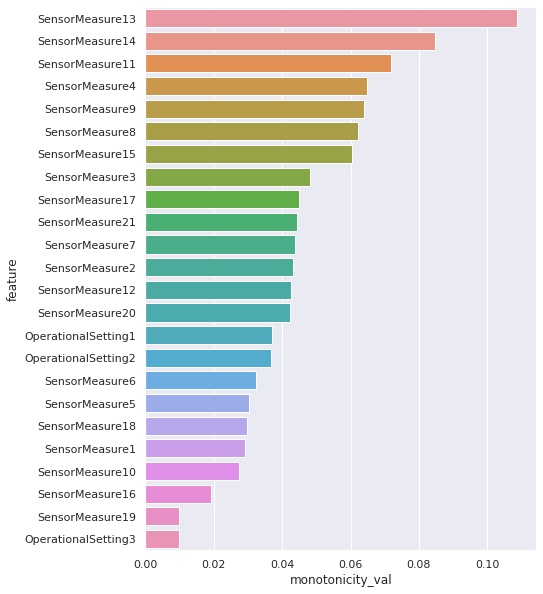

In [23]:
def plots(df,features_columns):
  mon_df = monotonicity_df(df, features_columns)
  mon_df.sort_values(by = 'monotonicity_val', ascending = False, inplace=True)
  fig, ax = plt.subplots(figsize = (7,10))
  sns.barplot(x = mon_df.monotonicity_val,y = mon_df.feature)
  
plots(train_data, features_columns)

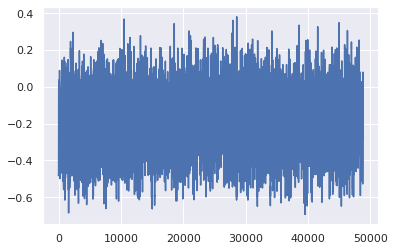

In [24]:
x = np.array(train_data['SensorMeasure2'])
plt.plot(x)

Smoothening the Sensor Data

To smoothen the data we have some methods


*   Rolling Window
*   Tsmoothie



In [25]:
# np.random.seed(33)

# data = sim_randomwalk(n_series=10, timesteps=200, 
#                       process_noise=10, measure_noise=30)


# # operate smoothing
# smoother = ExponentialSmoother(window_len=20, alpha=0.3)
# smoother.smooth(data)

# # # generate intervals
# # low, up = smoother.get_intervals('sigma_interval')

# # plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
# # plt.plot(smoother.data[0], '.k')
# # plt.xlabel('time')

# # # plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
# type(smoother.smooth_data)

In [26]:
# train_data_smooth = train_data
# for cols in train_data.columns:
#   smoother = ExponentialSmoother(window_len=20, alpha=0.3)
#   smoother.smooth(train_data[cols])
#   # generate intervals
#   low, up = smoother.get_intervals('sigma_interval')

#   train_data_smooth[cols] = pd.DataFrame(smoother.smooth_data) 


# LSTM

## Libraries

In [27]:
#for deep learning
import tensorflow as tf
from tensorflow import keras
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [28]:
with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


In [29]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} ) 
# ()
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
# tf.compat.v1.keras.backend

## Dataset Genearation

In [30]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
      lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [31]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [32]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [33]:
sequence_length = 50
mask_value = 0

In [34]:
#generate train
x_train=np.concatenate(list(list(gen_train(train_data[train_data['UnitNumber']==unit], sequence_length, features)) for unit in train_data['UnitNumber'].unique()))
print(x_train.shape)

(36079, 50, 18)


In [35]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(train_data[train_data['UnitNumber']==unit], sequence_length, "RUL")) for unit in train_data['UnitNumber'].unique()))
y_train.shape

(36079,)

In [36]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, features, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(259, 50, 18)


In [37]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(259,)

## Model

In [38]:
nb_features = x_train.shape[2]
nb_out = 1

In [39]:
nb_features

18

In [51]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.1))
model.add(LSTM(
          units=150,
          return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(units=100, activation='relu'))
# model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 100)           47600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 198,351
Trainable params: 198,351
Non-trainable params: 0
________________________________________________

## Training

In [52]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=50, batch_size=1000, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/50
33/33 [==============================] - 2s 59ms/step - loss: 6480.6694 - mse: 6480.6694 - val_loss: 7960.2148 - val_mse: 7960.2148
Epoch 2/50
33/33 [==============================] - 1s 40ms/step - loss: 5614.7168 - mse: 5614.7168 - val_loss: 7342.5620 - val_mse: 7342.5620
Epoch 3/50
33/33 [==============================] - 1s 40ms/step - loss: 5131.5347 - mse: 5131.5347 - val_loss: 6790.1885 - val_mse: 6790.1885
Epoch 4/50
33/33 [==============================] - 1s 40ms/step - loss: 4697.5703 - mse: 4697.5703 - val_loss: 6279.1855 - val_mse: 6279.1855
Epoch 5/50
33/33 [==============================] - 1s 40ms/step - loss: 4306.6440 - mse: 4306.6440 - val_loss: 5814.5234 - val_mse: 5814.5234
Epoch 6/50
33/33 [==============================] - 1s 40ms/step - loss: 3965.1812 - mse: 3965.1812 - val_loss: 5399.4395 - val_mse: 5399.4395
Epoch 7/50
33/33 [==============================] - 1s 40ms/step - loss: 3667.6079 - mse: 3667.6079 - val_loss: 5027.2656 - val_mse: 5027.2656

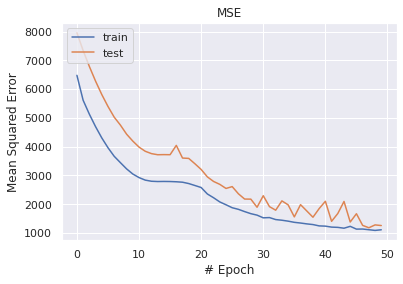

In [53]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
# print('MSE: {}'.format(scores_test[1]))

9/9 - 0s - loss: 1848.5114 - mse: 1848.5114


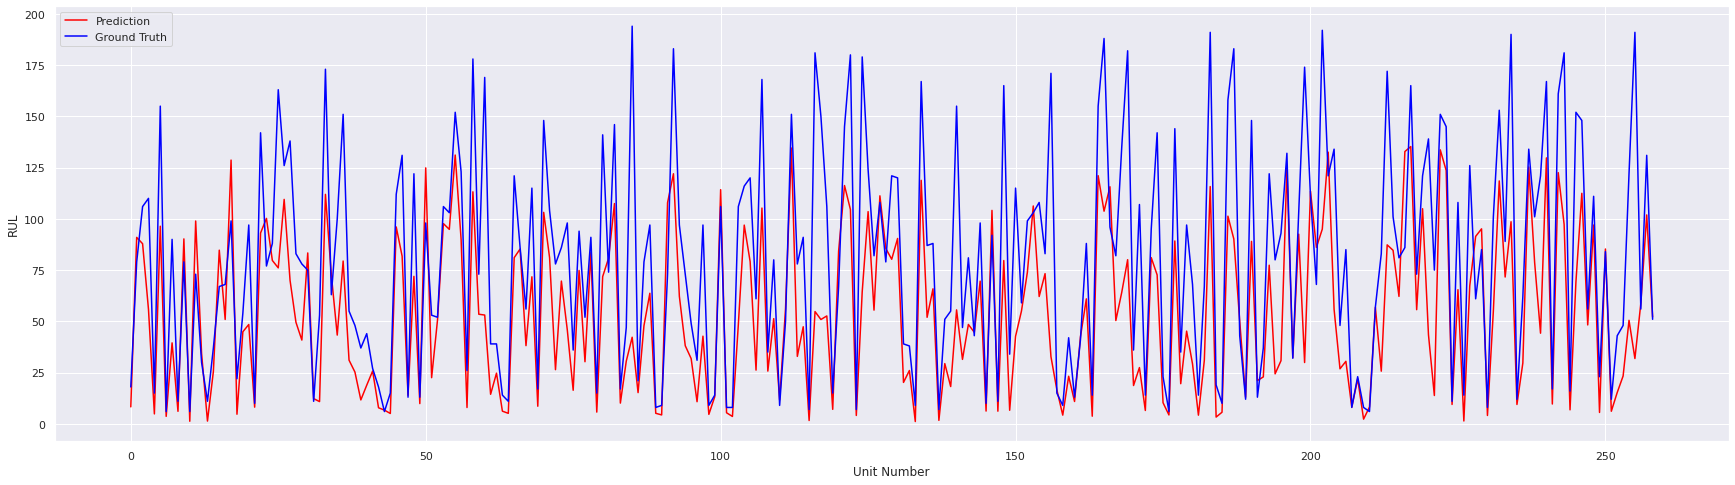

In [55]:
y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(30,8))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

# Exponential Degradation

## Data Preprocessing

# Similarity Based Degradation